In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
%cd /gdrive/My Drive/AN2DL/Exercise_4/

/gdrive/My Drive/AN2DL/Exercise_4


### Import libraries

In [3]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.6.0


### Set seed for reproducibility

In [4]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# UC Merced Land Use Dataset

http://weegee.vision.ucmerced.edu/datasets/landuse.html

Aerial RGB images of 256x256 pixels. Images belongs to 21 different classes representing the land uses.

Class labels:
0. agricultural
1. airplane
2. baseballdiamond
3. beach
4 .buildings
5. chaparral
6. denseresidential
7. forest
8. freeway
9. golfcourse
10. harbor
11. intersection
12. mediumresidential
13. mobilehomepark
14. overpass
15. parkinglot
16. river
17. runway
18. sparseresidential
19. storagetanks
20. tenniscourt

In [ ]:
# Load the dataset to be used for classification
!unzip UCMerced_LandUse.zip

Archive:  UCMerced_LandUse.zip
replace UCMerced_LandUse/test/agricultural/agricultural01.tif? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
N


In [5]:
# Dataset folders 
dataset_dir = 'UCMerced_LandUse'
training_dir = os.path.join(dataset_dir, 'training')
validation_dir = os.path.join(dataset_dir, 'validation')
test_dir = os.path.join(dataset_dir, 'test')

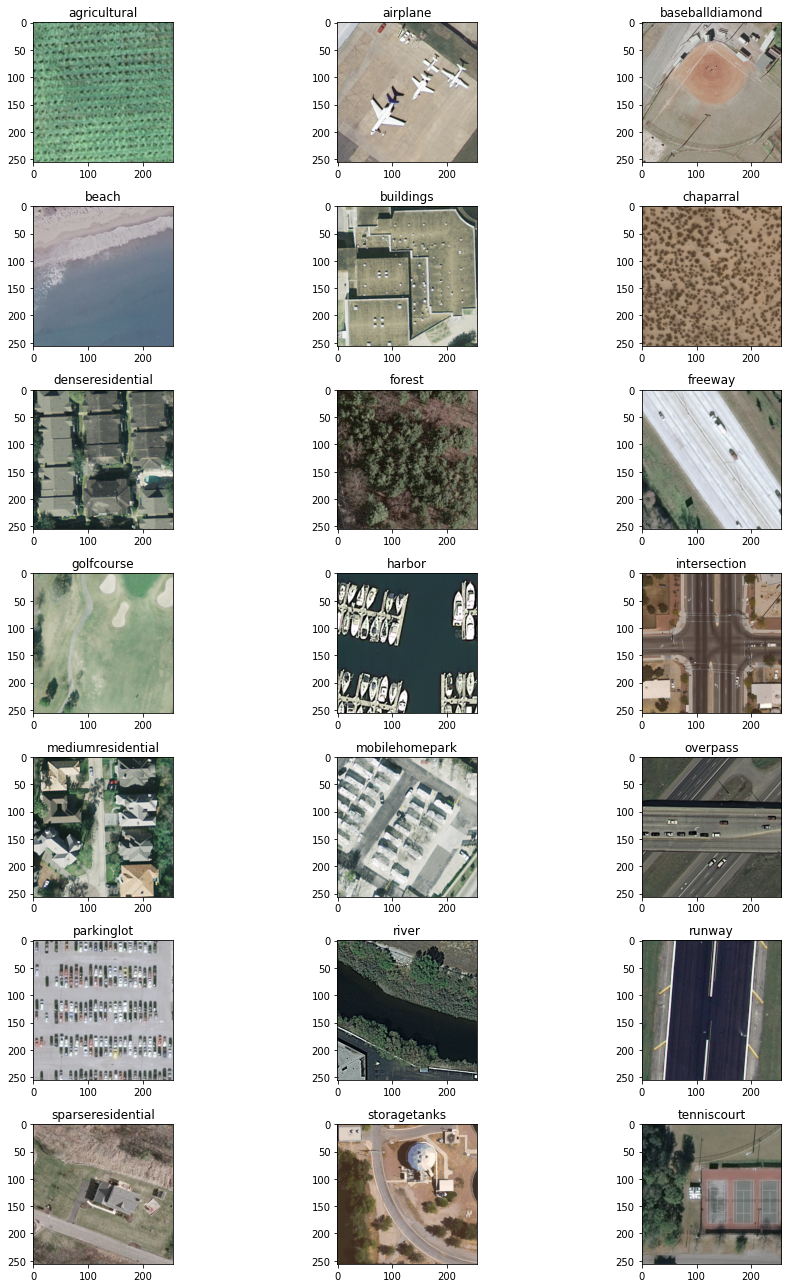

In [6]:
# Plot example images from dataset
labels = ['agricultural',       # 0
          'airplane',           # 1
          'baseballdiamond',    # 2
          'beach',              # 3
          'buildings',          # 4
          'chaparral',          # 5
          'denseresidential',   # 6
          'forest',             # 7
          'freeway',            # 8
          'golfcourse',         # 9
          'harbor',             # 10
          'intersection',       # 11
          'mediumresidential',  # 12
          'mobilehomepark',     # 13
          'overpass',           # 14
          'parkinglot',         # 15
          'river',              # 16
          'runway',             # 17
          'sparseresidential',  # 18
          'storagetanks',       # 19
          'tenniscourt']        # 20

num_row = 7
num_col = 3
fig, axes = plt.subplots(num_row, num_col, figsize=(2*num_row,6*num_col))
for i in range(num_row*num_col):
  if i < 21:
    class_imgs = next(os.walk('{}/training/{}/'.format(dataset_dir, labels[i])))[2]
    class_img = class_imgs[0]
    img = Image.open('{}/training/{}/{}'.format(dataset_dir, labels[i], class_img))
    ax = axes[i//num_col, i%num_col]
    ax.imshow(np.array(img))
    ax.set_title('{}'.format(labels[i]))
plt.tight_layout()
plt.show()

# Data Loader

### Typically, data is too large to be loaded as a NumPy array.
### We need a different strategy..

In [7]:
# Inspect dataset structure on disk
print("Depth 0 (UCMerced_LandUse")
print("-------")
!ls UCMerced_LandUse
print()
print("Depth 1 (e.g., UCMerced_LandUse/training)")
print("------------------------")
!ls UCMerced_LandUse/training
print()
print("Depth 2 (e.g., UCMerced_LandUse/training/agricultural)")
print("----------------------------")
!ls UCMerced_LandUse/training/agricultural


Depth 0 (UCMerced_LandUse
-------
test  training	validation

Depth 1 (e.g., UCMerced_LandUse/training)
------------------------
agricultural	 denseresidential  mediumresidential  sparseresidential
airplane	 forest		   mobilehomepark     storagetanks
baseballdiamond  freeway	   overpass	      tenniscourt
beach		 golfcourse	   parkinglot
buildings	 harbor		   river
chaparral	 intersection	   runway

Depth 2 (e.g., UCMerced_LandUse/training/agricultural)
----------------------------
agricultural00.tif  agricultural27.tif	agricultural53.tif  agricultural75.tif
agricultural02.tif  agricultural28.tif	agricultural54.tif  agricultural76.tif
agricultural03.tif  agricultural29.tif	agricultural55.tif  agricultural77.tif
agricultural04.tif  agricultural31.tif	agricultural56.tif  agricultural78.tif
agricultural05.tif  agricultural32.tif	agricultural58.tif  agricultural81.tif
agricultural07.tif  agricultural34.tif	agricultural59.tif  agricultural83.tif
agricultural09.tif  agricultural35.tif	agricult

In [8]:
# Images are divided into folders, one for each class. 
# If the images are organized in such a way, we can exploit the 
# ImageDataGenerator to read them from disk.
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an instance of ImageDataGenerator for training, validation, and test sets
train_data_gen = ImageDataGenerator()
valid_data_gen = ImageDataGenerator()
test_data_gen = ImageDataGenerator()

# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
train_gen = train_data_gen.flow_from_directory(directory=training_dir,
                                               target_size=(256,256),
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=8,
                                               shuffle=True,
                                               seed=seed)
valid_gen = train_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size=(256,256),
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=8,
                                               shuffle=False,
                                               seed=seed)
test_gen = train_data_gen.flow_from_directory(directory=test_dir,
                                              target_size=(256,256),
                                              color_mode='rgb',
                                              classes=None, # can be set to labels
                                              class_mode='categorical',
                                              batch_size=8,
                                              shuffle=False,
                                              seed=seed)

Found 1470 images belonging to 21 classes.
Found 315 images belonging to 21 classes.
Found 315 images belonging to 21 classes.


In [9]:
print("Assigned labels")
print(train_gen.class_indices)
print()
print("Target classes")
print(train_gen.classes)

Assigned labels
{'agricultural': 0, 'airplane': 1, 'baseballdiamond': 2, 'beach': 3, 'buildings': 4, 'chaparral': 5, 'denseresidential': 6, 'forest': 7, 'freeway': 8, 'golfcourse': 9, 'harbor': 10, 'intersection': 11, 'mediumresidential': 12, 'mobilehomepark': 13, 'overpass': 14, 'parkinglot': 15, 'river': 16, 'runway': 17, 'sparseresidential': 18, 'storagetanks': 19, 'tenniscourt': 20}

Target classes
[ 0  0  0 ... 20 20 20]


In [10]:
def get_next_batch(generator):
  batch = next(generator)

  image = batch[0]
  target = batch[1]

  print("(Input) image shape:", image.shape)
  print("Target shape:",target.shape)

  # Visualize only the first sample
  image = image[0]
  target = target[0]
  target_idx = np.argmax(target)
  print()
  print("Categorical label:", target)
  print("Label:", target_idx)
  print("Class name:", labels[target_idx])
  fig = plt.figure(figsize=(6, 4))
  plt.imshow(np.uint8(image))

  return batch

(Input) image shape: (8, 256, 256, 3)
Target shape: (8, 21)

Categorical label: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
Label: 14
Class name: overpass


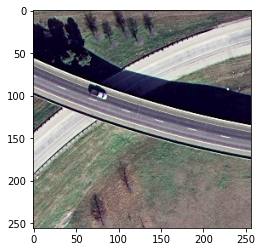

In [11]:
# Get a sample from dataset and show info
_ = get_next_batch(train_gen)

# Data Augmentation

##### ImageDataGenerator allows to perform data augmentation

```
tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=False, samplewise_center=False,
    featurewise_std_normalization=False, samplewise_std_normalization=False,
    zca_whitening=False, zca_epsilon=1e-06, rotation_range=0, width_shift_range=0.0,
    height_shift_range=0.0, brightness_range=None, shear_range=0.0, zoom_range=0.0,
    channel_shift_range=0.0, fill_mode='nearest', cval=0.0,
    horizontal_flip=False, vertical_flip=False, rescale=None,
    preprocessing_function=None, data_format=None, validation_split=0.0, dtype=None
)
```

Rotation: {'theta': -7.527592869158251, 'tx': 0, 'ty': 0, 'shear': 0, 'zx': 1, 'zy': 1, 'flip_horizontal': 0, 'flip_vertical': 0, 'channel_shift_intensity': None, 'brightness': None} 

Shift: {'theta': 0, 'tx': 0, 'ty': 38, 'shear': 0, 'zx': 1, 'zy': 1, 'flip_horizontal': 0, 'flip_vertical': 0, 'channel_shift_intensity': None, 'brightness': None} 

Zoom: {'theta': 0, 'tx': 0, 'ty': 0, 'shear': 0, 'zx': 0.9247240713084175, 'zy': 1.2704285838459497, 'flip_horizontal': 0, 'flip_vertical': 0, 'channel_shift_intensity': None, 'brightness': None} 

Flip: {'theta': 0, 'tx': 0, 'ty': 0, 'shear': 0, 'zx': 1, 'zy': 1, 'flip_horizontal': 1, 'flip_vertical': 0, 'channel_shift_intensity': None, 'brightness': None} 



Text(0.5, 1.0, 'Flipped')

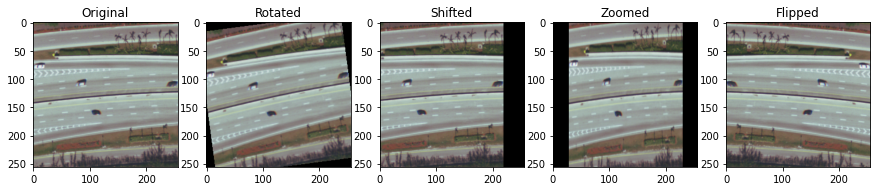

In [12]:
# Create some augmentation examples

# Get sample image
image = next(train_gen)[0][4]

# Create an instance of ImageDataGenerator for each transformation
rot_gen = ImageDataGenerator(rotation_range=30)
shift_gen = ImageDataGenerator(width_shift_range=50)
zoom_gen = ImageDataGenerator(zoom_range=0.3)
flip_gen = ImageDataGenerator(horizontal_flip=True)

# Get random transformations
rot_t = rot_gen.get_random_transform(img_shape=(256, 256), seed=seed)
print('Rotation:', rot_t, '\n')
shift_t = shift_gen.get_random_transform(img_shape=(256, 256), seed=seed)
print('Shift:', shift_t, '\n')
zoom_t = zoom_gen.get_random_transform(img_shape=(256, 256), seed=seed)
print('Zoom:', zoom_t, '\n')
flip_t = flip_gen.get_random_transform(img_shape=(256, 256), seed=seed)
print('Flip:', flip_t, '\n')

# Apply the transformation
gen = ImageDataGenerator(fill_mode='constant', cval=0.)
rotated = gen.apply_transform(image, rot_t)
shifted = gen.apply_transform(image, shift_t) 
zoomed = gen.apply_transform(image, zoom_t) 
flipped = gen.apply_transform(image, flip_t)  

# Plot original and augmented images
fig, ax = plt.subplots(1, 5, figsize=(15, 45))
ax[0].imshow(np.uint8(image))
ax[0].set_title('Original')
ax[1].imshow(np.uint8(rotated))
ax[1].set_title('Rotated')
ax[2].imshow(np.uint8(shifted))
ax[2].set_title('Shifted')
ax[3].imshow(np.uint8(zoomed))
ax[3].set_title('Zoomed')
ax[4].imshow(np.uint8(flipped))
ax[4].set_title('Flipped')

Transform: {'theta': -7.527592869158251, 'tx': -28, 'ty': 42, 'shear': 0, 'zx': 1.059195090518222, 'zy': 0.7936111842654618, 'flip_horizontal': 1, 'flip_vertical': 1, 'channel_shift_intensity': None, 'brightness': None}


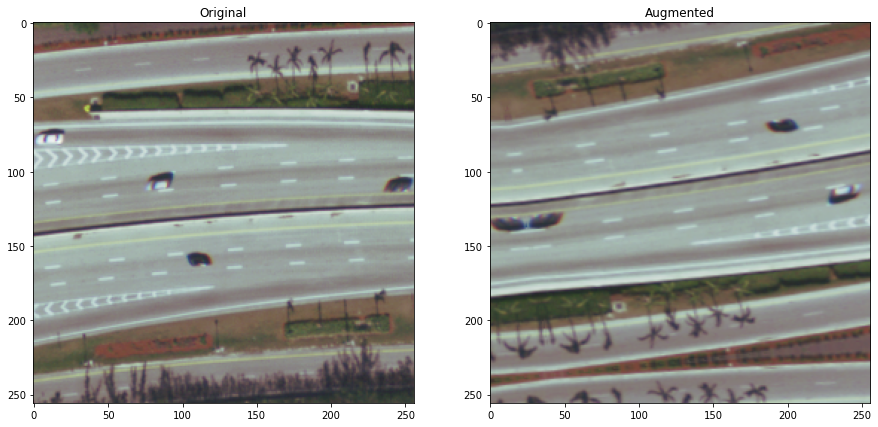

In [13]:
# Combine multiple transformations
gen = ImageDataGenerator(rotation_range=30,
                         height_shift_range=50,
                         width_shift_range=50,
                         zoom_range=0.3,
                         horizontal_flip=True,
                         vertical_flip=True, 
                         fill_mode='reflect')

# Get random transformation
t = gen.get_random_transform(img_shape=(256, 256), seed=seed)
print("Transform:", t)

# Apply the transformation
augmented = gen.apply_transform(image, t)

# Plot original and augmented images
fig, ax = plt.subplots(1, 2, figsize=(15,30))
ax[0].imshow(np.uint8(image))
ax[0].set_title("Original")
ax[1].imshow(np.uint8(augmented))
ax[1].set_title("Augmented")
plt.show()

# Training with and without data augmentation

In [14]:
# Create an instance of ImageDataGenerator with NO Data Augmentation
noaug_train_data_gen = ImageDataGenerator(rescale=1/255.) # rescale value is multiplied to the image
valid_data_gen = ImageDataGenerator(rescale=1/255.)
test_data_gen = ImageDataGenerator(rescale=1/255.)

# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
noaug_train_gen = noaug_train_data_gen.flow_from_directory(directory=training_dir,
                                                           target_size=(256,256),
                                                           color_mode='rgb',
                                                           classes=None, # can be set to labels
                                                           class_mode='categorical',
                                                           batch_size=8,
                                                           shuffle=True,
                                                           seed=seed)
valid_gen = valid_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size=(256,256),
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=8,
                                               shuffle=False,
                                               seed=seed)
test_gen = test_data_gen.flow_from_directory(directory=test_dir,
                                             target_size=(256,256),
                                             color_mode='rgb',
                                             classes=None, # can be set to labels
                                             class_mode='categorical',
                                             batch_size=8,
                                             shuffle=False,
                                             seed=seed)

Found 1470 images belonging to 21 classes.
Found 315 images belonging to 21 classes.
Found 315 images belonging to 21 classes.


In [15]:
# Create an instance of ImageDataGenerator with Data Augmentation
aug_train_data_gen = ImageDataGenerator(rotation_range=30,
                                        height_shift_range=50,
                                        width_shift_range=50,
                                        zoom_range=0.3,
                                        horizontal_flip=True,
                                        vertical_flip=True, 
                                        fill_mode='reflect',
                                        rescale=1/255.) # rescale value is multiplied to the image

# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
aug_train_gen = aug_train_data_gen.flow_from_directory(directory=training_dir,
                                                       target_size=(256,256),
                                                       color_mode='rgb',
                                                       classes=None, # can be set to labels
                                                       class_mode='categorical',
                                                       batch_size=8,
                                                       shuffle=True,
                                                       seed=seed)

Found 1470 images belonging to 21 classes.


### Models metadata

In [16]:
input_shape = (256, 256, 3)
epochs = 200

### CNN model

In [17]:
# Model used for the exercise:
# (Conv + ReLU + MaxPool) x 5 + FC x 2
def build_model(input_shape):

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    conv1 = tfkl.Conv2D(
        filters=16,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(input_layer)
    pool1 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv1)

    conv2 = tfkl.Conv2D(
        filters=32,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool1)
    pool2 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv2)

    conv3 = tfkl.Conv2D(
        filters=64,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool2)
    pool3 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv3)

    conv4 = tfkl.Conv2D(
        filters=128,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool3)
    pool4 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv4)

    conv5 = tfkl.Conv2D(
        filters=256,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool4)
    pool5 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv5)

    flattening_layer = tfkl.Flatten(name='Flatten')(pool5)
    flattening_layer = tfkl.Dropout(0.3, seed=seed)(flattening_layer)
    classifier_layer = tfkl.Dense(units=512, name='Classifier', kernel_initializer=tfk.initializers.GlorotUniform(seed), activation='relu')(flattening_layer)
    classifier_layer = tfkl.Dropout(0.3, seed=seed)(classifier_layer)
    output_layer = tfkl.Dense(units=21, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='Output')(classifier_layer)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [18]:
# Utility function to create folders and callbacks for training
from datetime import datetime

def create_folders_and_callbacks(model_name):

  exps_dir = os.path.join('data_augmentation_experiments')
  if not os.path.exists(exps_dir):
      os.makedirs(exps_dir)

  now = datetime.now().strftime('%b%d_%H-%M-%S')

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)
      
  callbacks = []

  # Model checkpoint
  # ----------------
  ckpt_dir = os.path.join(exp_dir, 'ckpts')
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), 
                                                     save_weights_only=False, # True to save only weights
                                                     save_best_only=False) # True to save only the best epoch 
  callbacks.append(ckpt_callback)

  # Visualize Learning on Tensorboard
  # ---------------------------------
  tb_dir = os.path.join(exp_dir, 'tb_logs')
  if not os.path.exists(tb_dir):
      os.makedirs(tb_dir)
      
  # By default shows losses and metrics for both training and validation
  tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir, 
                                               profile_batch=0,
                                               histogram_freq=1)  # if > 0 (epochs) shows weights histograms
  callbacks.append(tb_callback)

  # Early Stopping
  # --------------
  es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
  callbacks.append(es_callback)

  return callbacks

In [19]:
# Build model (for NO augmentation training)
model = build_model(input_shape)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 64)        0     

In [ ]:
# Create folders and callbacks and fit
noaug_callbacks = create_folders_and_callbacks(model_name='CNN_NoAug')

# Train the model
history = model.fit(
    x = noaug_train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks = noaug_callbacks,
).history

Epoch 1/200
184/184 [==============================] - 256s 1s/step - loss: 3.0090 - accuracy: 0.0626 - val_loss: 2.8662 - val_accuracy: 0.1302


INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_NoAug_Nov02_15-33-12/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_NoAug_Nov02_15-33-12/ckpts/cp.ckpt/assets


Epoch 2/200
184/184 [==============================] - 8s 45ms/step - loss: 2.5431 - accuracy: 0.1633 - val_loss: 2.1544 - val_accuracy: 0.2540


INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_NoAug_Nov02_15-33-12/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_NoAug_Nov02_15-33-12/ckpts/cp.ckpt/assets


Epoch 3/200
184/184 [==============================] - 9s 47ms/step - loss: 2.0112 - accuracy: 0.3395 - val_loss: 1.7743 - val_accuracy: 0.4444


INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_NoAug_Nov02_15-33-12/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_NoAug_Nov02_15-33-12/ckpts/cp.ckpt/assets


Epoch 4/200
184/184 [==============================] - 9s 48ms/step - loss: 1.4642 - accuracy: 0.5061 - val_loss: 1.4911 - val_accuracy: 0.5079


INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_NoAug_Nov02_15-33-12/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_NoAug_Nov02_15-33-12/ckpts/cp.ckpt/assets


Epoch 5/200
184/184 [==============================] - 9s 46ms/step - loss: 1.0669 - accuracy: 0.6551 - val_loss: 1.4311 - val_accuracy: 0.5365


INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_NoAug_Nov02_15-33-12/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_NoAug_Nov02_15-33-12/ckpts/cp.ckpt/assets


Epoch 6/200
184/184 [==============================] - 9s 48ms/step - loss: 0.7063 - accuracy: 0.7660 - val_loss: 1.6969 - val_accuracy: 0.5175


INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_NoAug_Nov02_15-33-12/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_NoAug_Nov02_15-33-12/ckpts/cp.ckpt/assets


Epoch 7/200
184/184 [==============================] - 8s 46ms/step - loss: 0.5590 - accuracy: 0.8143 - val_loss: 2.0181 - val_accuracy: 0.5365


INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_NoAug_Nov02_15-33-12/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_NoAug_Nov02_15-33-12/ckpts/cp.ckpt/assets


Epoch 8/200
184/184 [==============================] - 9s 49ms/step - loss: 0.3644 - accuracy: 0.8796 - val_loss: 1.8926 - val_accuracy: 0.5302


INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_NoAug_Nov02_15-33-12/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_NoAug_Nov02_15-33-12/ckpts/cp.ckpt/assets


Epoch 9/200
184/184 [==============================] - 10s 55ms/step - loss: 0.2794 - accuracy: 0.9129 - val_loss: 2.3755 - val_accuracy: 0.4857


INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_NoAug_Nov02_15-33-12/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_NoAug_Nov02_15-33-12/ckpts/cp.ckpt/assets


Epoch 10/200
184/184 [==============================] - 11s 61ms/step - loss: 0.1963 - accuracy: 0.9408 - val_loss: 2.3426 - val_accuracy: 0.5492


INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_NoAug_Nov02_15-33-12/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_NoAug_Nov02_15-33-12/ckpts/cp.ckpt/assets


Epoch 11/200
184/184 [==============================] - 10s 52ms/step - loss: 0.2037 - accuracy: 0.9408 - val_loss: 2.1645 - val_accuracy: 0.4984


INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_NoAug_Nov02_15-33-12/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_NoAug_Nov02_15-33-12/ckpts/cp.ckpt/assets


Epoch 12/200
184/184 [==============================] - 10s 54ms/step - loss: 0.1567 - accuracy: 0.9517 - val_loss: 2.5262 - val_accuracy: 0.5365


INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_NoAug_Nov02_15-33-12/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_NoAug_Nov02_15-33-12/ckpts/cp.ckpt/assets


Epoch 13/200
184/184 [==============================] - 10s 55ms/step - loss: 0.1234 - accuracy: 0.9633 - val_loss: 2.5901 - val_accuracy: 0.5492


INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_NoAug_Nov02_15-33-12/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_NoAug_Nov02_15-33-12/ckpts/cp.ckpt/assets


Epoch 14/200
184/184 [==============================] - 10s 55ms/step - loss: 0.1302 - accuracy: 0.9612 - val_loss: 2.6382 - val_accuracy: 0.5524


INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_NoAug_Nov02_15-33-12/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_NoAug_Nov02_15-33-12/ckpts/cp.ckpt/assets


Epoch 15/200
184/184 [==============================] - 10s 55ms/step - loss: 0.1350 - accuracy: 0.9544 - val_loss: 2.7587 - val_accuracy: 0.5619


INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_NoAug_Nov02_15-33-12/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_NoAug_Nov02_15-33-12/ckpts/cp.ckpt/assets


In [ ]:
# Save best epoch model
model.save("data_augmentation_experiments/CNN_NoAug_Best")

INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_NoAug_Best/assets


INFO:tensorflow:Assets written to: data_augmentation_experiments/CNN_NoAug_Best/assets


In [ ]:
# Build model (for data augmentation training)
model = build_model(input_shape)

In [ ]:
tf.get_logger().setLevel('WARNING') #  if you want to suppress only INFOs
# tf.get_logger().setLevel('ERROR') #  if you want to suppress both WARNINGs and INFOs

# Create folders and callbacks and fit
aug_callbacks = create_folders_and_callbacks(model_name='CNN_Aug')

# Train the model
history = model.fit(
    x = aug_train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks = aug_callbacks,
).history

Epoch 1/200
184/184 [==============================] - 31s 166ms/step - loss: 2.9757 - accuracy: 0.0619 - val_loss: 2.7333 - val_accuracy: 0.1079


Epoch 2/200
184/184 [==============================] - 29s 158ms/step - loss: 2.6108 - accuracy: 0.1449 - val_loss: 2.3884 - val_accuracy: 0.1937


Epoch 3/200
184/184 [==============================] - 29s 155ms/step - loss: 2.3857 - accuracy: 0.2041 - val_loss: 2.1637 - val_accuracy: 0.2857


Epoch 4/200
184/184 [==============================] - 29s 156ms/step - loss: 2.1154 - accuracy: 0.3061 - val_loss: 1.7721 - val_accuracy: 0.4000


Epoch 5/200
184/184 [==============================] - 29s 157ms/step - loss: 1.9044 - accuracy: 0.3476 - val_loss: 1.7823 - val_accuracy: 0.3810


Epoch 6/200
184/184 [==============================] - 29s 158ms/step - loss: 1.7115 - accuracy: 0.4259 - val_loss: 1.6343 - val_accuracy: 0.4794


Epoch 7/200
184/184 [==============================] - 29s 159ms/step - loss: 1.6139 - accuracy: 0.4721 - val_loss: 1.6084 - val_accuracy: 0.4571


Epoch 8/200
184/184 [==============================] - 29s 157ms/step - loss: 1.5501 - accuracy: 0.4728 - val_loss: 1.1441 - val_accuracy: 0.6063


Epoch 9/200
184/184 [==============================] - 29s 157ms/step - loss: 1.4605 - accuracy: 0.5122 - val_loss: 1.3916 - val_accuracy: 0.5460


Epoch 10/200
184/184 [==============================] - 30s 165ms/step - loss: 1.3728 - accuracy: 0.5367 - val_loss: 1.1228 - val_accuracy: 0.6063


Epoch 11/200
184/184 [==============================] - 29s 156ms/step - loss: 1.3770 - accuracy: 0.5361 - val_loss: 1.0645 - val_accuracy: 0.6317


Epoch 12/200
184/184 [==============================] - 29s 155ms/step - loss: 1.3102 - accuracy: 0.5639 - val_loss: 1.0720 - val_accuracy: 0.6063


Epoch 13/200
184/184 [==============================] - 28s 152ms/step - loss: 1.1835 - accuracy: 0.5925 - val_loss: 1.0279 - val_accuracy: 0.6222


Epoch 14/200
184/184 [==============================] - 28s 154ms/step - loss: 1.1843 - accuracy: 0.6143 - val_loss: 1.1308 - val_accuracy: 0.6000


Epoch 15/200
184/184 [==============================] - 29s 159ms/step - loss: 1.1891 - accuracy: 0.6000 - val_loss: 0.9958 - val_accuracy: 0.6413


Epoch 16/200
184/184 [==============================] - 29s 159ms/step - loss: 1.0757 - accuracy: 0.6354 - val_loss: 0.9026 - val_accuracy: 0.7048


Epoch 17/200
184/184 [==============================] - 29s 156ms/step - loss: 1.0697 - accuracy: 0.6381 - val_loss: 0.7736 - val_accuracy: 0.7397


Epoch 18/200
184/184 [==============================] - 29s 159ms/step - loss: 1.0339 - accuracy: 0.6388 - val_loss: 0.8489 - val_accuracy: 0.6825


Epoch 19/200
184/184 [==============================] - 31s 167ms/step - loss: 1.0300 - accuracy: 0.6442 - val_loss: 0.9791 - val_accuracy: 0.6349


Epoch 20/200
184/184 [==============================] - 31s 170ms/step - loss: 0.9984 - accuracy: 0.6599 - val_loss: 0.7470 - val_accuracy: 0.7333


Epoch 21/200
184/184 [==============================] - 29s 156ms/step - loss: 0.9414 - accuracy: 0.6721 - val_loss: 0.7438 - val_accuracy: 0.7397


Epoch 22/200
184/184 [==============================] - 29s 157ms/step - loss: 0.9175 - accuracy: 0.6912 - val_loss: 0.7771 - val_accuracy: 0.7270


Epoch 23/200
184/184 [==============================] - 29s 157ms/step - loss: 0.8249 - accuracy: 0.7122 - val_loss: 0.7547 - val_accuracy: 0.7238


Epoch 24/200
184/184 [==============================] - 31s 171ms/step - loss: 0.9380 - accuracy: 0.6850 - val_loss: 0.7828 - val_accuracy: 0.7206


Epoch 25/200
184/184 [==============================] - 32s 172ms/step - loss: 0.9204 - accuracy: 0.6844 - val_loss: 0.7410 - val_accuracy: 0.7270


Epoch 26/200
184/184 [==============================] - 29s 157ms/step - loss: 0.8939 - accuracy: 0.6891 - val_loss: 0.6412 - val_accuracy: 0.7619


Epoch 27/200
184/184 [==============================] - 29s 157ms/step - loss: 0.8102 - accuracy: 0.7109 - val_loss: 0.5641 - val_accuracy: 0.8095


Epoch 28/200
184/184 [==============================] - 29s 157ms/step - loss: 0.8245 - accuracy: 0.7163 - val_loss: 0.9219 - val_accuracy: 0.7143


Epoch 29/200
184/184 [==============================] - 29s 158ms/step - loss: 0.7589 - accuracy: 0.7306 - val_loss: 0.6967 - val_accuracy: 0.7778


Epoch 30/200
184/184 [==============================] - 29s 160ms/step - loss: 0.7625 - accuracy: 0.7456 - val_loss: 0.6137 - val_accuracy: 0.7841


Epoch 31/200
184/184 [==============================] - 32s 173ms/step - loss: 0.7951 - accuracy: 0.7238 - val_loss: 0.6542 - val_accuracy: 0.7746


Epoch 32/200
184/184 [==============================] - 31s 171ms/step - loss: 0.7733 - accuracy: 0.7279 - val_loss: 0.6614 - val_accuracy: 0.7492


Epoch 33/200
184/184 [==============================] - 32s 172ms/step - loss: 0.7891 - accuracy: 0.7367 - val_loss: 0.6973 - val_accuracy: 0.7683


Epoch 34/200
184/184 [==============================] - 32s 175ms/step - loss: 0.7487 - accuracy: 0.7531 - val_loss: 0.5429 - val_accuracy: 0.8095


Epoch 35/200
184/184 [==============================] - 29s 159ms/step - loss: 0.7334 - accuracy: 0.7605 - val_loss: 0.5292 - val_accuracy: 0.7905


Epoch 36/200
184/184 [==============================] - 29s 159ms/step - loss: 0.6675 - accuracy: 0.7762 - val_loss: 0.5588 - val_accuracy: 0.7905


Epoch 37/200
184/184 [==============================] - 29s 159ms/step - loss: 0.7325 - accuracy: 0.7469 - val_loss: 0.6191 - val_accuracy: 0.8000


Epoch 38/200
184/184 [==============================] - 31s 167ms/step - loss: 0.6930 - accuracy: 0.7585 - val_loss: 0.5241 - val_accuracy: 0.8317


Epoch 39/200
184/184 [==============================] - 29s 157ms/step - loss: 0.7003 - accuracy: 0.7639 - val_loss: 0.5952 - val_accuracy: 0.7905


Epoch 40/200
184/184 [==============================] - 29s 158ms/step - loss: 0.7350 - accuracy: 0.7599 - val_loss: 0.5136 - val_accuracy: 0.8349


Epoch 41/200
184/184 [==============================] - 29s 159ms/step - loss: 0.6576 - accuracy: 0.7707 - val_loss: 0.4815 - val_accuracy: 0.8476


Epoch 42/200
184/184 [==============================] - 29s 159ms/step - loss: 0.6356 - accuracy: 0.7789 - val_loss: 0.5644 - val_accuracy: 0.8159


Epoch 43/200
184/184 [==============================] - 30s 161ms/step - loss: 0.5870 - accuracy: 0.7993 - val_loss: 0.4614 - val_accuracy: 0.8444


Epoch 44/200
184/184 [==============================] - 30s 162ms/step - loss: 0.6610 - accuracy: 0.7884 - val_loss: 0.4675 - val_accuracy: 0.7873


Epoch 45/200
184/184 [==============================] - 29s 159ms/step - loss: 0.5770 - accuracy: 0.8020 - val_loss: 0.4675 - val_accuracy: 0.8635


Epoch 46/200
184/184 [==============================] - 32s 172ms/step - loss: 0.6918 - accuracy: 0.7721 - val_loss: 0.4933 - val_accuracy: 0.8317


Epoch 47/200
184/184 [==============================] - 32s 174ms/step - loss: 0.5927 - accuracy: 0.7993 - val_loss: 0.4690 - val_accuracy: 0.8413


Epoch 48/200
184/184 [==============================] - 33s 178ms/step - loss: 0.6496 - accuracy: 0.7857 - val_loss: 0.4218 - val_accuracy: 0.8603


Epoch 49/200
184/184 [==============================] - 30s 161ms/step - loss: 0.6096 - accuracy: 0.8027 - val_loss: 0.5541 - val_accuracy: 0.7968


Epoch 50/200
184/184 [==============================] - 29s 159ms/step - loss: 0.5739 - accuracy: 0.7925 - val_loss: 0.5174 - val_accuracy: 0.8286


Epoch 51/200
184/184 [==============================] - 31s 168ms/step - loss: 0.6371 - accuracy: 0.7918 - val_loss: 0.4389 - val_accuracy: 0.8476


Epoch 52/200
184/184 [==============================] - 32s 174ms/step - loss: 0.6014 - accuracy: 0.7912 - val_loss: 0.4920 - val_accuracy: 0.8349


Epoch 53/200
184/184 [==============================] - 31s 170ms/step - loss: 0.6256 - accuracy: 0.7816 - val_loss: 0.5988 - val_accuracy: 0.8063


Epoch 54/200
184/184 [==============================] - 32s 172ms/step - loss: 0.6070 - accuracy: 0.8020 - val_loss: 0.4023 - val_accuracy: 0.8825


Epoch 55/200
184/184 [==============================] - 29s 159ms/step - loss: 0.6300 - accuracy: 0.7776 - val_loss: 0.4180 - val_accuracy: 0.8508


Epoch 56/200
184/184 [==============================] - 29s 158ms/step - loss: 0.5613 - accuracy: 0.8197 - val_loss: 0.4126 - val_accuracy: 0.8603


Epoch 57/200
184/184 [==============================] - 31s 168ms/step - loss: 0.6449 - accuracy: 0.7952 - val_loss: 0.4968 - val_accuracy: 0.8444


Epoch 58/200
184/184 [==============================] - 31s 171ms/step - loss: 0.5679 - accuracy: 0.8088 - val_loss: 0.4216 - val_accuracy: 0.8349


Epoch 59/200
184/184 [==============================] - 32s 172ms/step - loss: 0.4840 - accuracy: 0.8347 - val_loss: 0.4774 - val_accuracy: 0.8571


Epoch 60/200
184/184 [==============================] - 31s 171ms/step - loss: 0.5378 - accuracy: 0.8245 - val_loss: 0.4202 - val_accuracy: 0.8413


Epoch 61/200
184/184 [==============================] - 31s 171ms/step - loss: 0.5188 - accuracy: 0.8218 - val_loss: 0.5653 - val_accuracy: 0.8127


Epoch 62/200
184/184 [==============================] - 32s 173ms/step - loss: 0.5377 - accuracy: 0.8218 - val_loss: 0.3540 - val_accuracy: 0.8889


Epoch 63/200
184/184 [==============================] - 29s 157ms/step - loss: 0.5601 - accuracy: 0.8306 - val_loss: 0.3930 - val_accuracy: 0.8730


Epoch 64/200
184/184 [==============================] - 29s 156ms/step - loss: 0.5279 - accuracy: 0.8143 - val_loss: 0.3982 - val_accuracy: 0.8889


Epoch 65/200
184/184 [==============================] - 31s 167ms/step - loss: 0.4836 - accuracy: 0.8333 - val_loss: 0.3782 - val_accuracy: 0.8730


Epoch 66/200
184/184 [==============================] - 31s 171ms/step - loss: 0.4927 - accuracy: 0.8245 - val_loss: 0.4164 - val_accuracy: 0.8698


Epoch 67/200
184/184 [==============================] - 31s 170ms/step - loss: 0.5344 - accuracy: 0.8211 - val_loss: 0.3977 - val_accuracy: 0.8667


Epoch 68/200
184/184 [==============================] - 31s 169ms/step - loss: 0.5288 - accuracy: 0.8095 - val_loss: 0.4023 - val_accuracy: 0.8698


Epoch 69/200
184/184 [==============================] - 32s 172ms/step - loss: 0.5094 - accuracy: 0.8367 - val_loss: 0.5370 - val_accuracy: 0.8222


Epoch 70/200
184/184 [==============================] - 31s 170ms/step - loss: 0.5147 - accuracy: 0.8340 - val_loss: 0.3288 - val_accuracy: 0.8984


Epoch 71/200
184/184 [==============================] - 29s 156ms/step - loss: 0.4644 - accuracy: 0.8490 - val_loss: 0.4832 - val_accuracy: 0.8508


Epoch 72/200
184/184 [==============================] - 29s 157ms/step - loss: 0.5105 - accuracy: 0.8293 - val_loss: 0.5250 - val_accuracy: 0.8603


Epoch 73/200
184/184 [==============================] - 32s 172ms/step - loss: 0.4952 - accuracy: 0.8313 - val_loss: 0.3801 - val_accuracy: 0.8730


Epoch 74/200
184/184 [==============================] - 32s 173ms/step - loss: 0.4900 - accuracy: 0.8340 - val_loss: 0.5075 - val_accuracy: 0.8349


Epoch 75/200
184/184 [==============================] - 32s 174ms/step - loss: 0.4870 - accuracy: 0.8286 - val_loss: 0.4991 - val_accuracy: 0.8476


Epoch 76/200
184/184 [==============================] - 32s 172ms/step - loss: 0.4866 - accuracy: 0.8313 - val_loss: 0.4263 - val_accuracy: 0.8762


Epoch 77/200
184/184 [==============================] - 32s 172ms/step - loss: 0.4993 - accuracy: 0.8259 - val_loss: 0.4355 - val_accuracy: 0.8508


Epoch 78/200
184/184 [==============================] - 32s 172ms/step - loss: 0.5269 - accuracy: 0.8184 - val_loss: 0.5249 - val_accuracy: 0.8603


Epoch 79/200
184/184 [==============================] - 32s 173ms/step - loss: 0.5381 - accuracy: 0.8211 - val_loss: 0.3483 - val_accuracy: 0.8762


Epoch 80/200
184/184 [==============================] - 32s 173ms/step - loss: 0.4753 - accuracy: 0.8388 - val_loss: 0.3580 - val_accuracy: 0.8698


In [ ]:
# Save best epoch model
model.save("data_augmentation_experiments/CNN_Aug_Best")

In [20]:
# Evaluate on test
# Trainined with no data augmentation
model_noaug = tfk.models.load_model("data_augmentation_experiments/CNN_NoAug_Best")
model_noaug_test_metrics = model_noaug.evaluate(test_gen, return_dict=True)
# Trained with data augmentation
model_aug = tfk.models.load_model("data_augmentation_experiments/CNN_Aug_Best")
model_aug_test_metrics = model_aug.evaluate(test_gen, return_dict=True)

print()
print("Test metrics without data augmentation")
print(model_noaug_test_metrics)
print("Test metrics with data augmentation")
print(model_aug_test_metrics)

40/40 [==============================] - 8s 195ms/step - loss: 0.4608 - accuracy: 0.8127

Test metrics without data augmentation
{'loss': 1.4527822732925415, 'accuracy': 0.5396825671195984}
Test metrics with data augmentation
{'loss': 0.460782527923584, 'accuracy': 0.8126984238624573}


# Visualize the activations

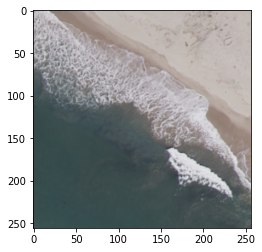

In [27]:
# Get sample batch
batch = next(test_gen)[0]

# Get first image
image = batch[3] # batch size = 8

fig = plt.figure(figsize=(6, 4))
plt.imshow(np.uint8(image*255))

In [28]:
# Get the activations (the output of each ReLU layer)
# We can do it by creating a new Model (activation_model) with the same input as 
# the original model and all the ReLU activations as output
layers = [layer.output for layer in model_aug.layers if isinstance(layer, tf.keras.layers.Conv2D)]
activation_model = tf.keras.Model(inputs=model_aug.input, outputs=layers)
# Finally we get the output feature maps (for each layer) given the imput test image
fmaps = activation_model.predict(tf.expand_dims(image, 0))

In [29]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
%matplotlib inline
def display_activation(fmaps, depth=0, first_n=-1): 
    # fmaps: list of all the feature maps for each layer
    # depth: the layer we want to visualize (an int in [0, network depth))
    # first_n: default '-1' means 'all activations'. Number of activations to be visualized. Note that for deep layers it could be a large number.

    fmaps = fmaps[depth] # get feature maps at the desired depth
    if first_n > 0:
      fmaps = fmaps[0, :, :, :first_n] 
    fmaps = tf.image.resize(fmaps, size=[128, 128]) # resize for visualization

    # Distribute on a grid for plotting
    col_size = 8
    row_size = fmaps.shape[-1] // 8
    fmap_channel=0
    fig = plt.figure(figsize=(30, 30))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                    nrows_ncols=(row_size, col_size),  
                    axes_pad=0.1,  # pad between axes in inch.
                    )
    for row in range(0,row_size):
        for col in range(0,col_size):
            grid[fmap_channel].imshow(fmaps[0, :, :, fmap_channel], cmap='gray', aspect='auto')
            fmap_channel += 1
    plt.show()

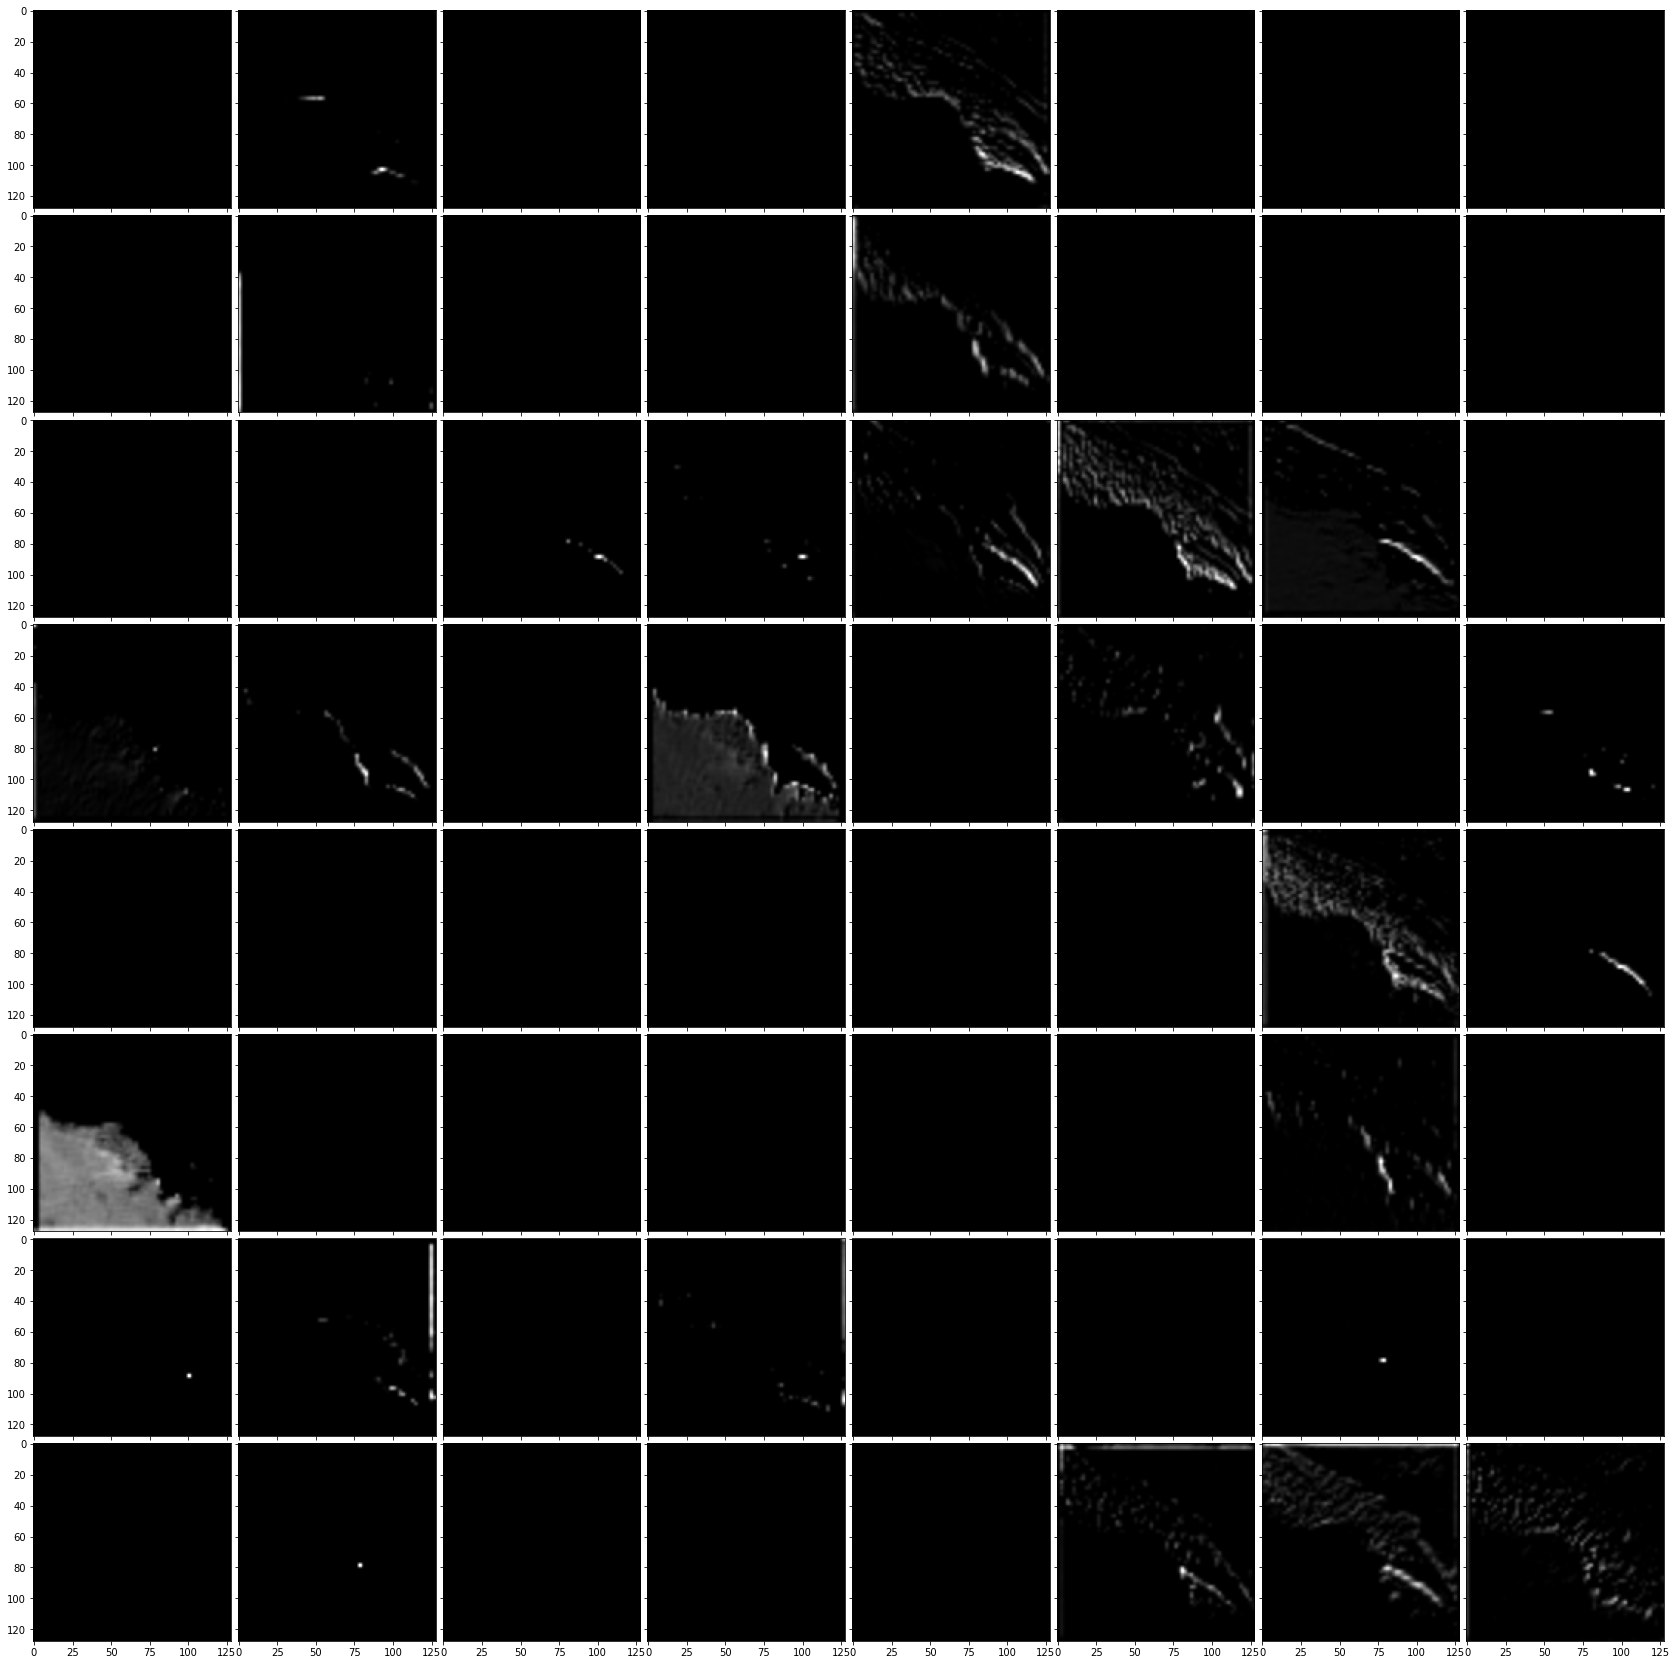

In [31]:
display_activation(fmaps=fmaps, depth=2, first_n=-1)